<h1>GMM improvement algorithm</h1>

In [243]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import permutations
from itertools import combinations

In [ ]:
data = pd.read_csv('activities.csv')
print(data.columns)

#Elapsed time
#Moving time
#Distance
#Activity Type
#Max heart rate
#Relative effort
#Average Heart Rate
#Elevation Gain
#Average Positive Grade
#Activity Date

#Make sure we are only polling rows and metrics that are useful
df = data[['Activity Type', 'Moving Time', 'Elapsed Time', 'Distance', 'Elevation Gain', 'Max Speed', 'Average Speed', "Activity Date"]]#, 'Max Heart Rate', 'Average Heart Rate']]

dfhr = df.iloc[:][df['Activity Type'] == 'Run']
#see output for why we don't use heart rate in GMM (Not enough activities with heartrate data to get good results)
print(data['Average Heart Rate'])

dfhr = dfhr.dropna()

Index(['Activity ID', 'Activity Date', 'Activity Name', 'Activity Type',
       'Activity Description', 'Elapsed Time', 'Distance', 'Max Heart Rate',
       'Relative Effort', 'Commute', 'Activity Private Note', 'Activity Gear',
       'Filename', 'Athlete Weight', 'Bike Weight', 'Elapsed Time.1',
       'Moving Time', 'Distance.1', 'Max Speed', 'Average Speed',
       'Elevation Gain', 'Elevation Loss', 'Elevation Low', 'Elevation High',
       'Max Grade', 'Average Grade', 'Average Positive Grade',
       'Average Negative Grade', 'Max Cadence', 'Average Cadence',
       'Max Heart Rate.1', 'Average Heart Rate', 'Max Watts', 'Average Watts',
       'Calories', 'Max Temperature', 'Average Temperature',
       'Relative Effort.1', 'Total Work', 'Number of Runs', 'Uphill Time',
       'Downhill Time', 'Other Time', 'Perceived Exertion', 'Type',
       'Start Time', 'Weighted Average Power', 'Power Count',
       'Prefer Perceived Exertion', 'Perceived Relative Effort', 'Commute.1',
    

In [ ]:

#Clean up data while keeping order intact (only modifications to columns not rows)
dfhrc = dfhr.drop(columns=['Activity Type', 'Elapsed Time', "Activity Date"])
dfhrc['Distance'] = dfhrc['Distance'].astype('float')
dfhrc = dfhrc[['Moving Time', 'Distance', 'Elevation Gain', 'Max Speed', 'Average Speed']]#, 'Average Heart Rate']]
times = dfhr['Activity Date']
speed = dfhr['Average Speed']
tim = dfhr['Elapsed Time']

print(dfhrc)

     Moving Time  Distance  Elevation Gain  Max Speed  Average Speed
16        1494.0      4.91       62.058334   5.641998       3.289833
17        1855.0      5.38       69.340065   8.568000       2.904280
18        1764.0      5.37       58.356316   5.431999       3.048010
19        2089.0      6.46       94.535156   6.631000       3.094304
20        2119.0      6.13      112.436714   4.952002       2.893605
..           ...       ...             ...        ...            ...
148        391.0      1.64        4.398461   7.200000       4.212020
149       2009.0      5.51       29.333326   5.020000       2.746391
150       1910.0      5.49       29.397490   6.800000       2.877906
151       1292.0      5.18       26.652857   6.980000       4.015170
152       1987.0      5.33       32.262691   7.670000       2.683946

[97 rows x 5 columns]


In [246]:
def pdf(x, m, cov): #This is the pdf fuction used when regularization is not needed
    xm = x - m
    d = len(x)
    frac = 1/(((2*np.pi)**(d/2))*np.linalg.det(cov))**.5 #Pdf equation
    exp = np.exp(-.5*np.dot(xm.T, np.dot(np.linalg.inv(cov), xm)))
    return exp * frac

In [ ]:
def stable_pdf(x, mean, cov): #This is the pdf function used when regularization is needed
    d = len(x)
    cov_reg = cov + 1e-6 * np.eye(d)  # regularization to avoid zeros
    try:
        cov_det = np.linalg.det(cov_reg)
        cov_inv = np.linalg.inv(cov_reg)
    except np.linalg.LinAlgError: #This seemed to happen a ton so this makes the code run consistently
        return 1e-300

    if cov_det <= 0 or np.isnan(cov_det): #Same as before would cause errors
        return 1e-300

    norm_const = 1.0 / (np.sqrt((2 * np.pi) ** d * cov_det)) #makes sure probability distributions area does not exceed 1
    diff = x - mean
    exponent = -0.5 * diff.T @ cov_inv @ diff
    return max(norm_const * np.exp(exponent), 1e-300) #returning zero causes errors

In [ ]:
def GMM(dat, k, tol=1e-4, max_iter=1000000000):
    #regularize values so results aren't skewed
    scaler = StandardScaler() 
    dat = scaler.fit_transform(dat)

    #Make sure we automatically fit to the data's shape then initialize all values
    r, d = dat.shape
    p_class = np.ones(k) / k
    covars = np.array([np.eye(d) for _ in range(k)])
    means = dat[np.random.choice(r, k, replace=False)]
    oldMeans = np.copy(means)
    meanDiff = np.inf

    for iteration in range(max_iter):
        if meanDiff <= tol: #if we break the tolerance threshold finish
            break
        
        #Compute Resposibilities (Expectations Step)
        resp = np.zeros((r, k))
        for a in range(r):
            for b in range(k):
                resp[a, b] = stable_pdf(dat[a], means[b], covars[b]) * p_class[b]
            denom = resp[a, :].sum()
            resp[a, :] /= denom if denom > 1e-12 else 1e-12 #Make sure we do not get close to inf or Nan

        #Update K Means, Covariables and Probability classes (Maximize Step)
        for c in range(k):
            weight = np.sum(resp[:, c])
            means[c] = np.sum(resp[:, c, None] * dat, axis=0) / weight
            diff = dat - means[c]
            covars[c] = (resp[:, c, None, None] * np.einsum('ni,nj->nij', diff, diff)).sum(axis=0) / weight
            covars[c] += 1e-6 * np.eye(d)
            p_class[c] = weight / r

        meanDiff = np.linalg.norm(means - oldMeans)
        oldMeans = np.copy(means)

    return resp, means, covars, p_class

In [ ]:
#Do GMM clustering
resp, means, covars, p_class =GMM(dfhrc, 5, .000000015)
print(dfhrc.columns)

Index(['Moving Time', 'Distance', 'Elevation Gain', 'Max Speed',
       'Average Speed'],
      dtype='object')


In [ ]:
def compute_log_likelihood(X, means, covars, p_class):
    r, k = X.shape[0], len(means) #get dimensions of what we need to iterate through
    ll = 0
    for i in range(r):
        prob = 0
        for j in range(k):
            prob += p_class[j] * pdf(X[i], means[j], covars[j]) #No issues from not regularizign so using normal pdf function
        ll += np.log(prob + 1e-10)#prevent log 0
    return ll

In [ ]:
options = ['Moving Time','Distance', 'Elevation Gain','Max Speed', 'Average Speed']
mi =  -np.inf
win = []
#Function only works sometimes, why idk, but in an earlier iteration of the program it was used to decide features used and number of k means
#TLDR don't run but look at
for permutation in permutations(options, 4):
    resp1, means1, covars1, p_class1 =GMM(dfhr[list(permutation)], 5, .000000015)
    l = compute_log_likelihood(resp1, means1, covars1, p_class1)
    if(l > mi): #find the highest log likelyhood generated and save it
        mi = l
        win = permutation
        print(permutation)
        resp3, means3, covars3, p_class3 = resp1, means1, covars1, p_class1
    print("K value ",5,": ", compute_log_likelihood(resp1, means1, covars1, p_class1))
print(win)

ValueError: operands could not be broadcast together with shapes (5,) (4,) 

In [ ]:
#Compute performance value of every activity (Works because all dataframes preserve order)
performance = ( .5*dfhr['Average Speed'] + .3*dfhrc['Distance'] / dfhr['Elapsed Time'] + .2*dfhr['Elevation Gain'])
print(dfhr['Elapsed Time'])

16     3468
17     1965
18     1811
19     2262
20     2159
       ... 
148     391
149    2017
150    1935
151    1292
152    1993
Name: Elapsed Time, Length: 97, dtype: int64


In [ ]:

#Algorithm to plot gmm Clusters
def plot_gmm(date_series, avg_speed_series, cluster_ids, title, xlabel, ylabel, date=False):
    if date: #Is the algorithm indexed by date or not
        df = pd.DataFrame({
            'date': pd.to_datetime(date_series),
            'speed': avg_speed_series,
            'cluster': cluster_ids
        })

        df = df.sort_values(by='date')
        df['date_ordinal'] = df['date'].map(pd.Timestamp.toordinal)

        plt.figure(figsize=(12, 6))

        unique_clusters = sorted(df['cluster'].unique())
        colors = plt.cm.tab10.colors  # max 10 colors

        for i, cluster in enumerate(unique_clusters):
            sub_df = df[df['cluster'] == cluster]

            plt.scatter(sub_df['date'], sub_df['speed'],
                        color=colors[i % len(colors)],
                        alpha=0.6,
                        label=f"Cluster {cluster}")

            # Line of best fit for this cluster
            x = sub_df['date_ordinal'].values
            y = sub_df['speed'].values
            if len(x) > 1:
                coeffs = np.polyfit(x, y, deg=1)
                trend = np.poly1d(coeffs)
                plt.plot(sub_df['date'], trend(x),
                        color=colors[i % len(colors)],
                        linestyle='--',
                        label=f"Trend {cluster}")
    else:
        df = pd.DataFrame({
            'elapsed_time': date_series,
            'speed': avg_speed_series,
            'cluster': cluster_ids
        })

        df = df.sort_values(by='elapsed_time')

        plt.figure(figsize=(12, 6))

        unique_clusters = sorted(df['cluster'].unique())
        colors = plt.cm.tab10.colors  # max 10 colors

        for i, cluster in enumerate(unique_clusters):
            sub_df = df[df['cluster'] == cluster]

            # Scatter plot for this cluster
            plt.scatter(sub_df['elapsed_time'], sub_df['speed'],
                        color=colors[i % len(colors)],
                        alpha=0.6,
                        label=f"Cluster {cluster}")

            # Line of best fit for this cluster
            x = sub_df['elapsed_time'].values
            y = sub_df['speed'].values
            if len(x) > 1:
                coeffs = np.polyfit(x, y, deg=1)
                trend = np.poly1d(coeffs)
                plt.plot(sub_df['elapsed_time'], trend(x),
                        color=colors[i % len(colors)],
                        linestyle='--',
                        label=f"Trend {cluster}")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.show()


<h1>Plots Made Below</h1>

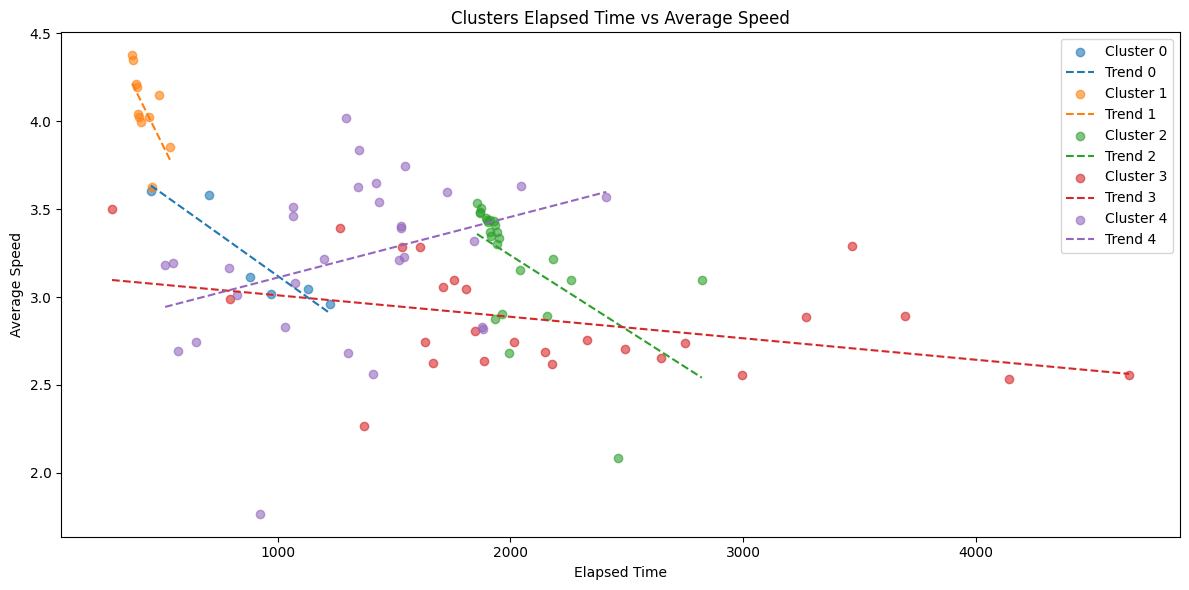

In [ ]:
plot_gmm(dfhr['Elapsed Time'], dfhr['Average Speed'], np.argmax(resp, axis=1), "Clusters Elapsed Time vs Average Speed", "Elapsed Time", "Average Speed")

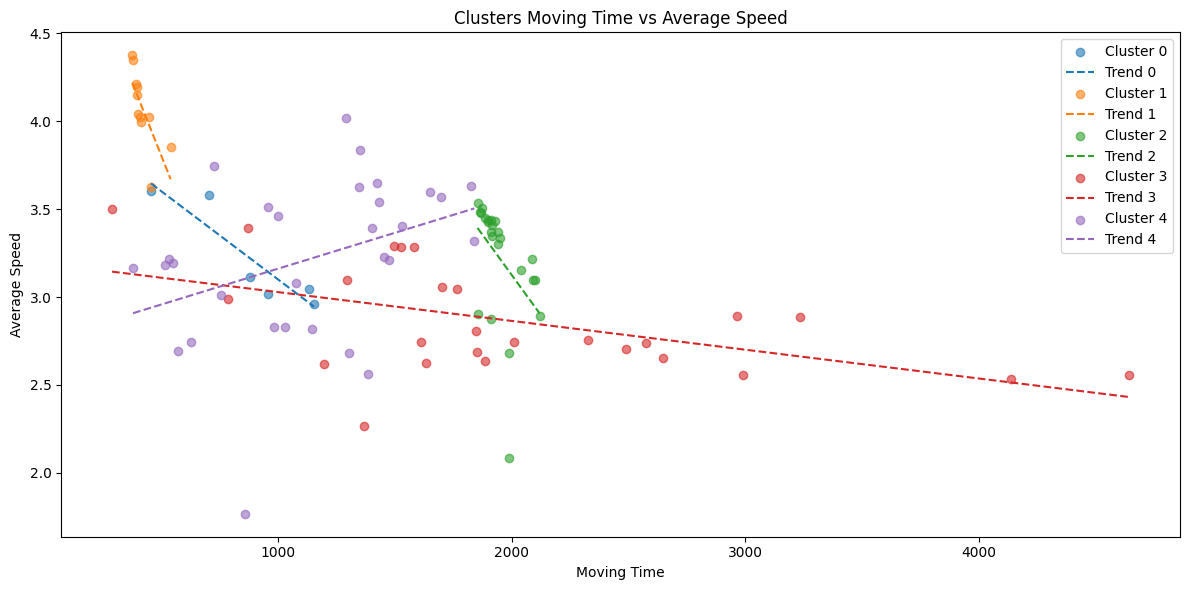

In [225]:
plot_gmm(dfhr['Moving Time'], dfhr['Average Speed'], np.argmax(resp, axis=1), "Clusters Moving Time vs Average Speed", "Moving Time", "Average Speed")

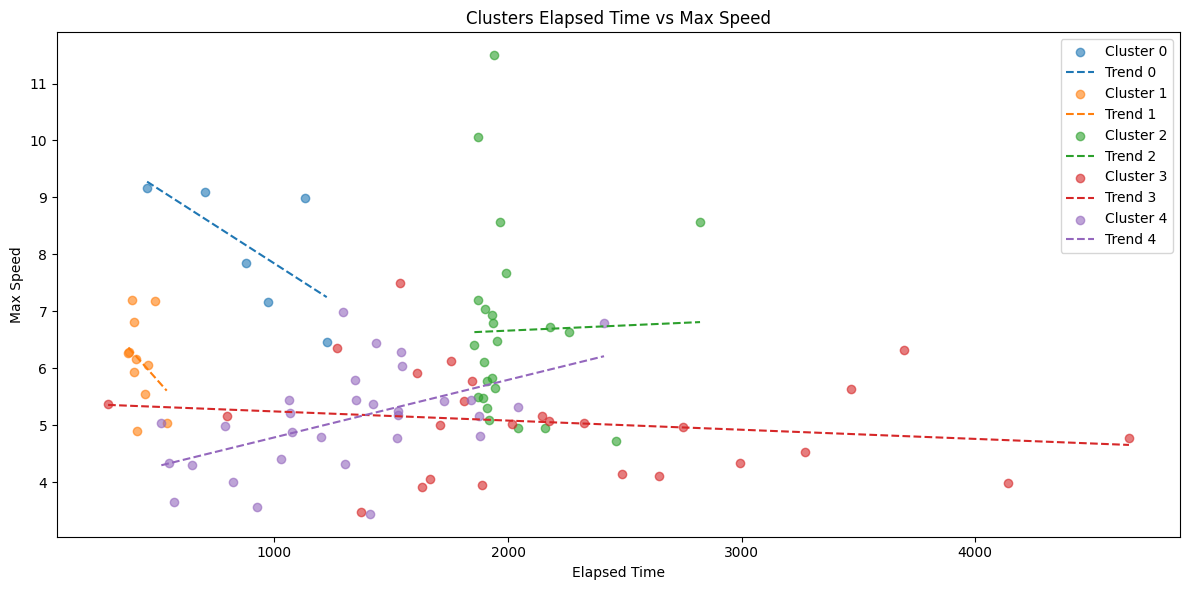

In [226]:
plot_gmm(dfhr['Elapsed Time'], dfhr['Max Speed'], np.argmax(resp, axis=1), "Clusters Elapsed Time vs Max Speed", "Elapsed Time", "Max Speed")

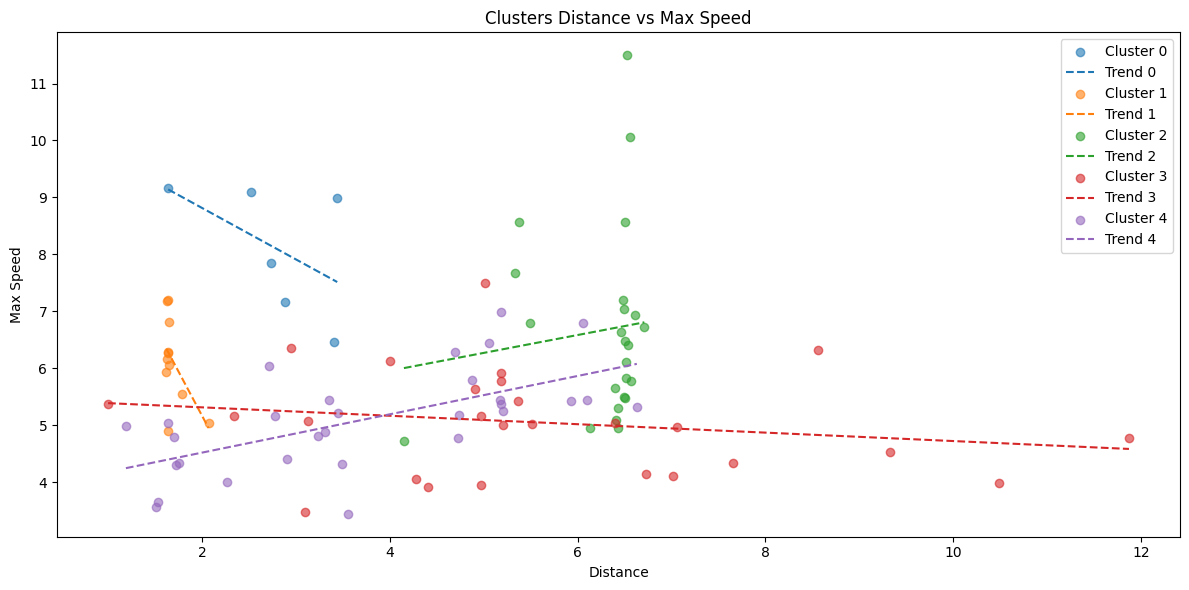

In [227]:
plot_gmm(dfhr['Distance'], dfhr['Max Speed'], np.argmax(resp, axis=1), "Clusters Distance vs Max Speed", "Distance", "Max Speed")

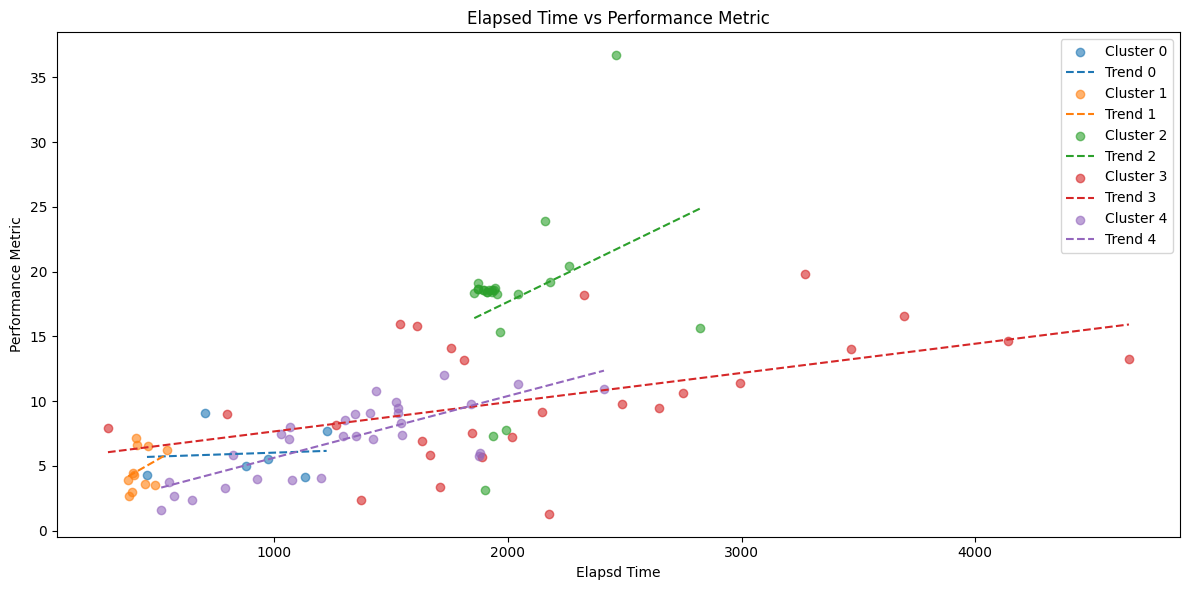

In [195]:
plot_gmm(dfhr['Elapsed Time'], performance, np.argmax(resp, axis=1), "Elapsed Time vs Performance Metric", "Elapsd Time", "Performance Metric")

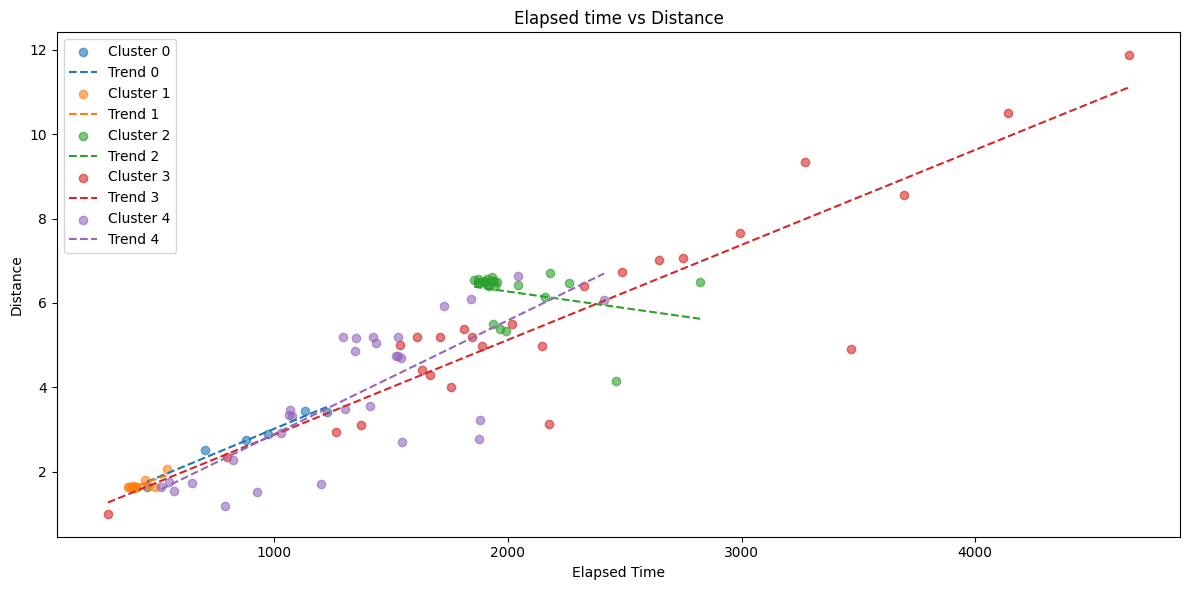

In [199]:
plot_gmm(dfhr['Elapsed Time'], dfhrc['Distance'], np.argmax(resp, axis=1), "Elapsed time vs Distance", "Elapsed Time", "Distance")

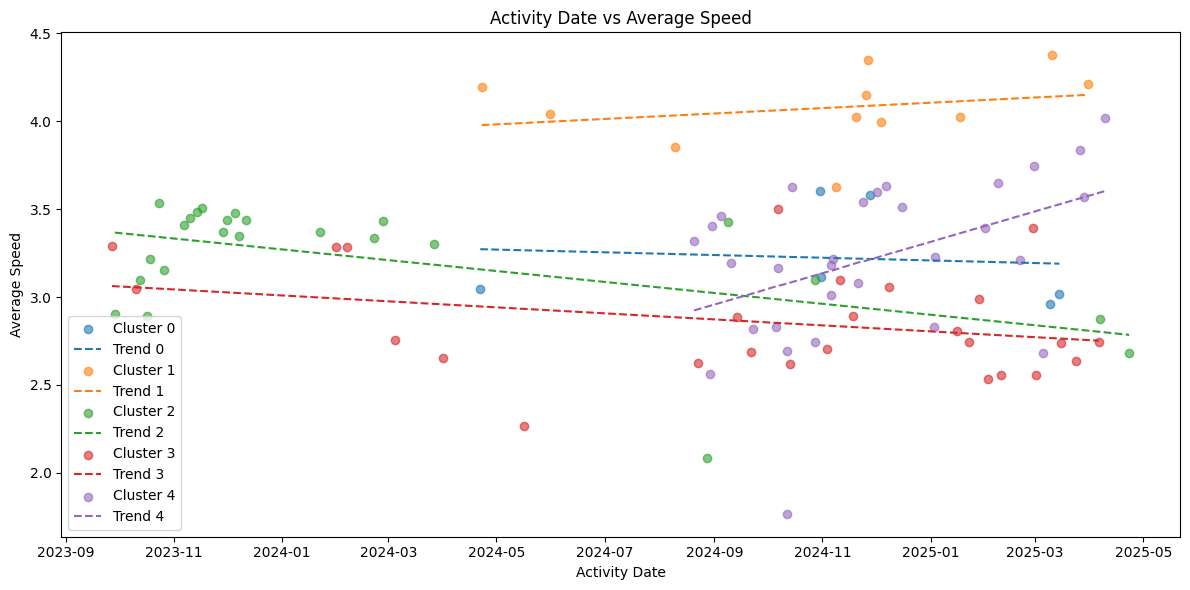

In [201]:
plot_gmm(dfhr['Activity Date'], dfhrc['Average Speed'], np.argmax(resp, axis=1), "Activity Date vs Average Speed", "Activity Date", "Average Speed", date=True)

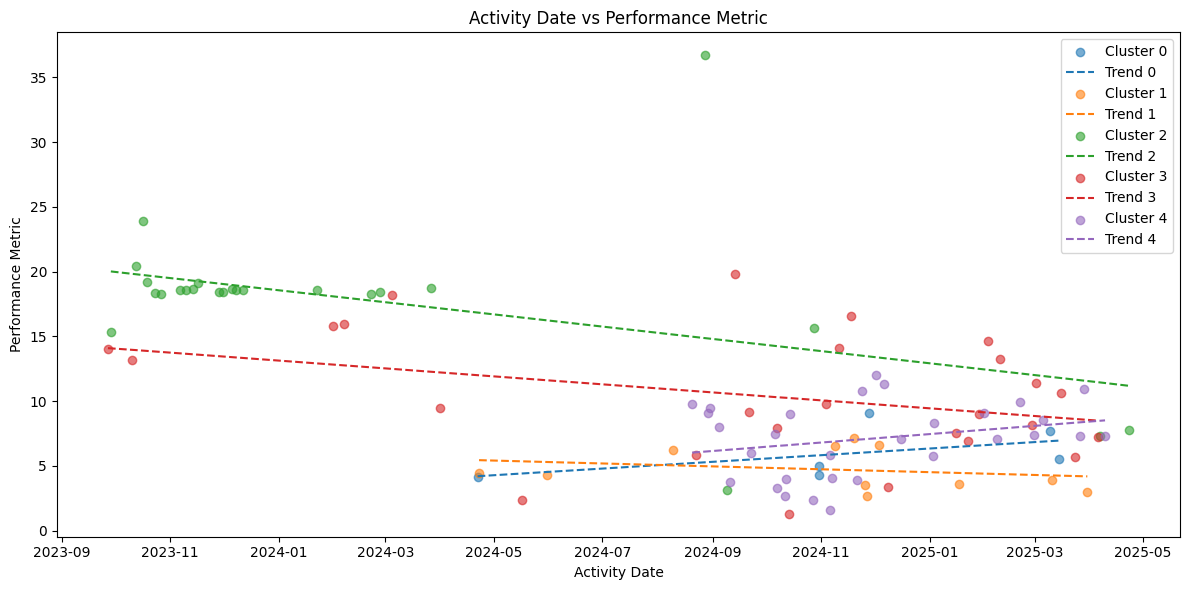

In [202]:
plot_gmm(dfhr['Activity Date'], performance, np.argmax(resp, axis=1), "Activity Date vs Performance Metric", "Activity Date", "Performance Metric", date=True)

In [ ]:
#Function to plot individual cluster trends over time
def plot_cluster_scatter_with_trend(date_series, avg_speed_series, cluster_ids, ylabel):
    df = pd.DataFrame({
        'date': pd.to_datetime(date_series),
        'speed': avg_speed_series,
        'cluster': cluster_ids
    })

    df = df.sort_values(by='date')
    df['date_ordinal'] = df['date'].map(pd.Timestamp.toordinal)

    unique_clusters = sorted(df['cluster'].unique())
    fig, axes = plt.subplots(len(unique_clusters), 1, figsize=(10, 4 * len(unique_clusters)), sharex=False)

    if len(unique_clusters) == 1:
        axes = [axes]  

    for i, cluster in enumerate(unique_clusters):
        sub_df = df[df['cluster'] == cluster]
        ax = axes[i]
        ax.scatter(sub_df['date'], sub_df['speed'], alpha=0.6, label=f"Cluster {cluster}")


        x = sub_df['date_ordinal'].values
        y = sub_df['speed'].values
        if len(x) > 1:
            coeffs = np.polyfit(x, y, deg=1)
            trend = np.poly1d(coeffs)
            ax.plot(sub_df['date'], trend(x), color='black', linestyle='--', label='Trend Line')

        ax.set_title(f"Cluster {cluster}: "+ylabel+" Over Time")
        ax.set_ylabel("Avg Speed")
        ax.legend()
        ax.grid(False)

    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()


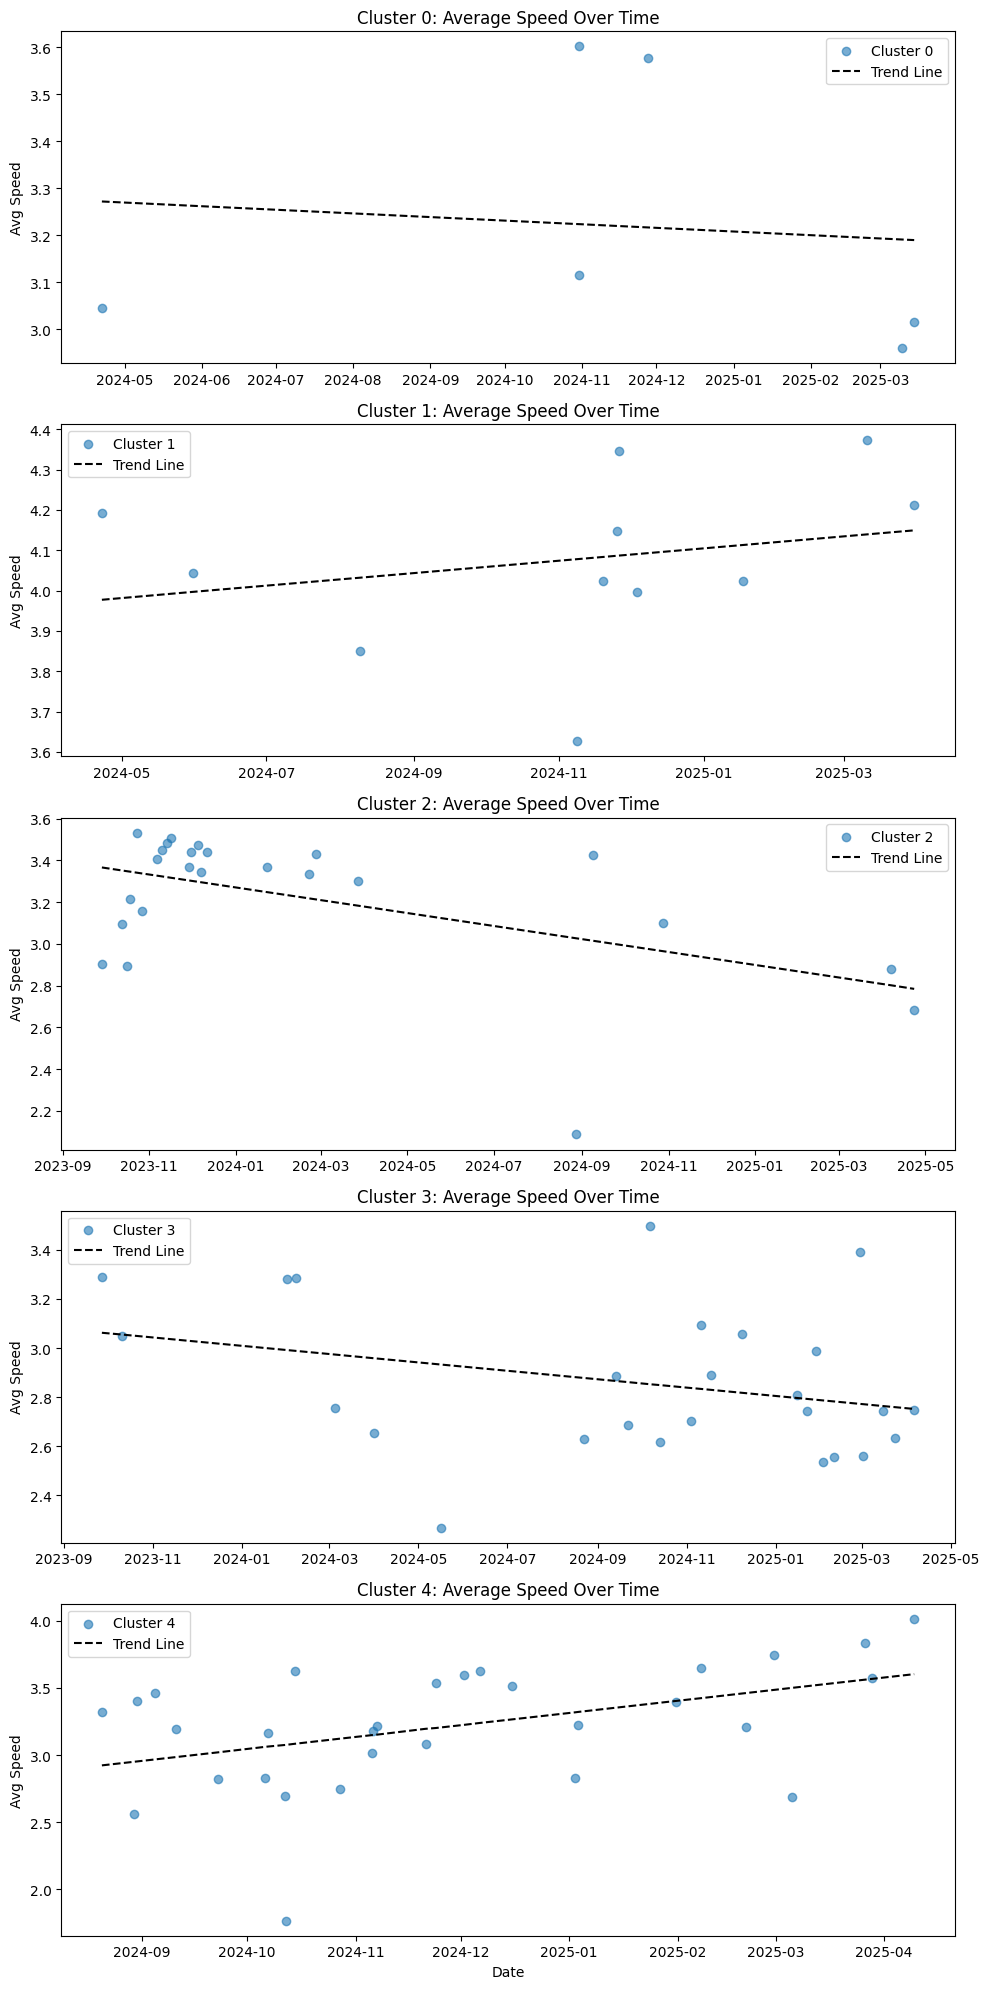

In [231]:
plot_cluster_scatter_with_trend(dfhr['Activity Date'], dfhrc['Average Speed'],  np.argmax(resp, axis=1), "Average Speed")

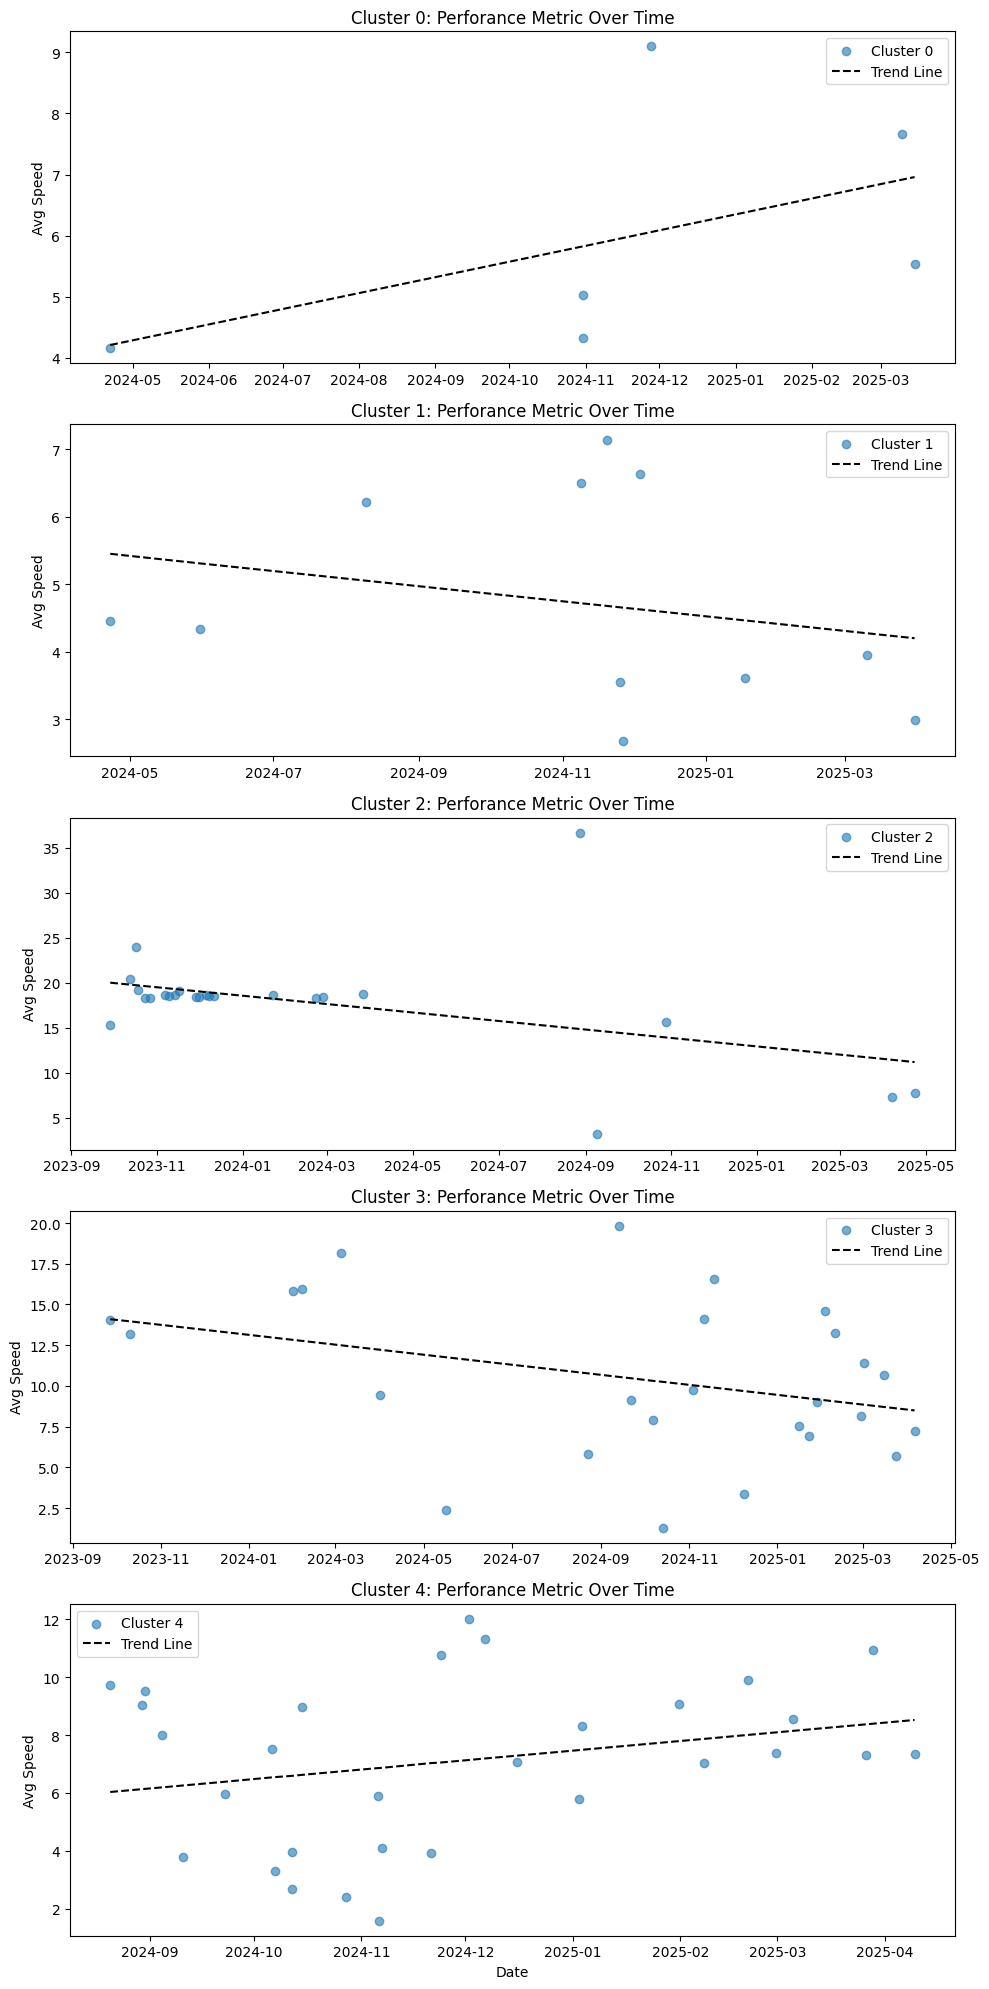

In [232]:
plot_cluster_scatter_with_trend(dfhr['Activity Date'], performance,  np.argmax(resp, axis=1), "Perforance Metric")

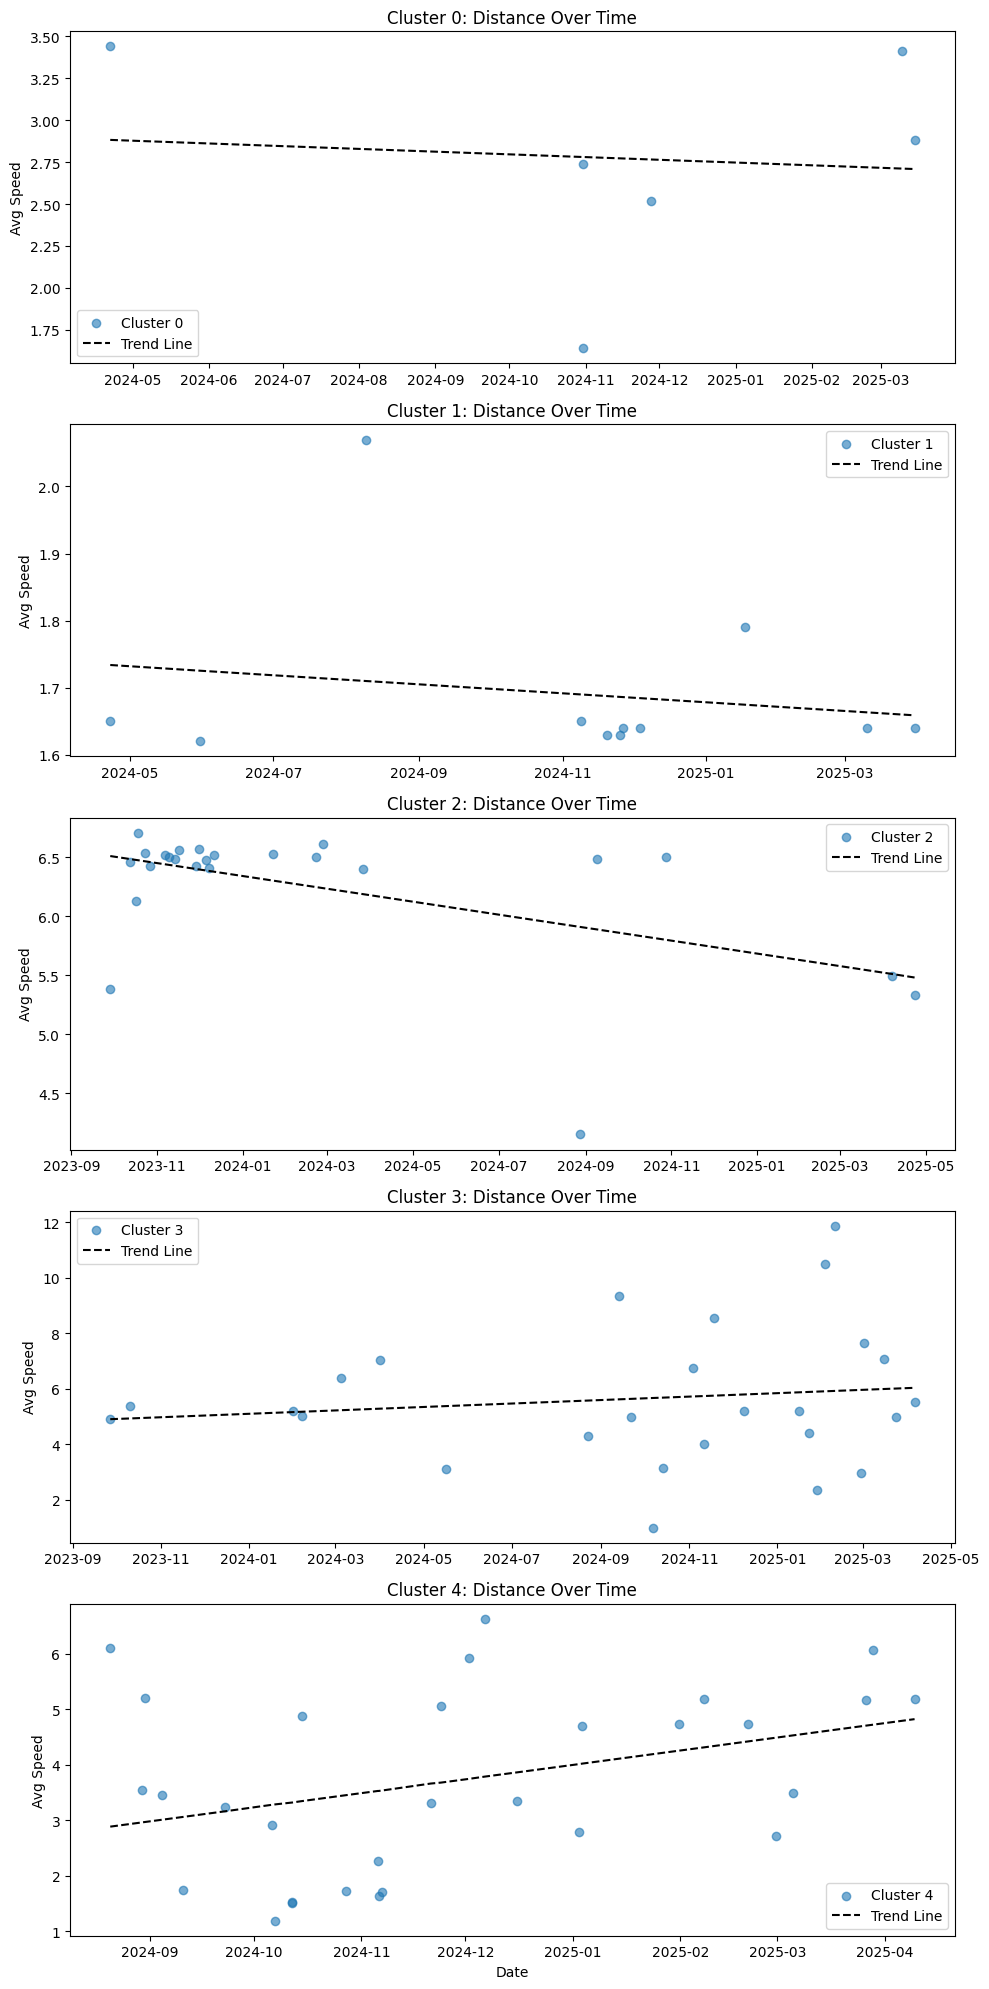

In [233]:
plot_cluster_scatter_with_trend(dfhr['Activity Date'], dfhrc['Distance'],  np.argmax(resp, axis=1), "Distance")